1) In iterator,py, we need to take optimization metric = sum of info 
2) fix info max in data
3) fix input for proposal operations
4) Move _unused_push to state and update unused nodes over there.

In [ ]:
alist = [1,2,3,4]
alist.index(3) # 3 un indexi, returns 2
alist[2] # the number at index, returns 3

2

In [1]:
import sys
from pathlib import Path

# Add the project root (the parent of the current directory) to sys.path
root = Path.cwd().parents[0]
if str(root) not in sys.path:
    sys.path.insert(0, str(root))



from uav_routing.socp import Solver
from uav_routing.data import grid_3x3, tour_info_decreasing

#nodes, cycle, data = grid_3x3()
nodes, cycle, data = tour_info_decreasing()


In [2]:
cycle.edges

OutEdgeView([(0, 1), (1, 2), (2, 3), (3, 0)])

In [3]:
cycle.nodes

NodeView((0, 1, 2, 3))

In [4]:
import math 

distances = {}
for edge in cycle.edges:
    u,v = edge
    point1, point2 = nodes[u]["position"], nodes[v]["position"]
    distances[(u,v)] = math.dist(point1, point2)
distances

{(0, 1): 1.0, (1, 2): 1.0, (2, 3): 1.0, (3, 0): 3.0}

In [5]:
# Initialize solver
tour = cycle
solver = Solver(
    nodes=nodes,
    tour_nodes=list(tour.nodes),
    distances=distances,
    tour_edges=list(tour.edges),
    metadata=data,
    threads=1,
    log_output=True
)
# Print initial solution
print("Initial objective:", solver.objective_value)
if solver.solution:
    for var in solver.model.iter_continuous_vars():
        print(var.name, solver.solution.get_value(var))

Version identifier: 22.1.2.0 | 2024-12-09 | 8bd2200c8
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
Tried aggregator 1 time.
QCP Presolve eliminated 1 rows and 1 columns.
Aggregator did 10 substitutions.
Reduced QCP has 43 rows, 37 columns, and 85 nonzeros.
Reduced QCP has 12 quadratic constraints.
Presolve time = 0.00 sec. (0.03 ticks)
Parallel mode: none, using 1 thread for barrier
Number of nonzeros in lower triangle of A*A' = 163
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.01 ticks)
Summary statistics for Cholesky factor:
  Rows in Factor            = 43
  Integer space required    = 61
  Total non-zeros in factor = 287
  Total FP ops to factor    = 2343
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf Inf Ratio
   0   2.4020000e+02   2.4000000e+02  1.02e+04  0.00e+00  4.44e+01  2.00e-01
   1   2.4095088e+02   2.3719972e+02  1.02e+04  0.00e+00  4.44e+01  4.40e-02

In [2]:
import sys
from pathlib import Path

# Add the project root (the parent of the current directory) to sys.path
root = Path.cwd().parents[0]
if str(root) not in sys.path:
    sys.path.insert(0, str(root))



from uav_routing.socp import Solver
from uav_routing.data import grid_3x3, tour_info_decreasing, tour_info_increasing, tour_optimum_speed

#nodes, cycle, data = grid_3x3()
#nodes, cycle, data = tour_info_increasing()

nodes, cycle, data = tour_optimum_speed()

## $$ = \mathbf{v_{opt} \approx 18.1170353}$$

In [3]:
import math 

distances = {}
for edge in cycle.edges:
    u,v = edge
    point1, point2 = nodes[u]["position"], nodes[v]["position"]
    distances[(u,v)] = math.dist(point1, point2)
distances

# Initialize solver
tour = cycle
solver = Solver(
    nodes=nodes,
    tour_nodes=list(tour.nodes),
    distances=distances,
    tour_edges=list(tour.edges),
    metadata=data,
    threads=1,
    log_output=True
)
# Print initial solution
print("Initial objective:", solver.objective_value)
if solver.solution:
    for var in solver.model.iter_continuous_vars():
        print(var.name, solver.solution.get_value(var))

Version identifier: 22.1.2.0 | 2024-12-09 | 8bd2200c8
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
Tried aggregator 1 time.
QCP Presolve eliminated 2 rows and 2 columns.
Aggregator did 10 substitutions.
Reduced QCP has 43 rows, 36 columns, and 82 nonzeros.
Reduced QCP has 12 quadratic constraints.
Presolve time = 0.00 sec. (0.03 ticks)
Parallel mode: none, using 1 thread for barrier
Number of nonzeros in lower triangle of A*A' = 152
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.01 ticks)
Summary statistics for Cholesky factor:
  Rows in Factor            = 43
  Integer space required    = 46
  Total non-zeros in factor = 285
  Total FP ops to factor    = 2309
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf Inf Ratio
   0   4.0000000e+01   4.0000000e+01  2.18e+04  0.00e+00  4.40e+01  1.00e+00
   1   4.0000000e+01   3.2803913e+01  2.18e+04  0.00e+00  4.40e+01  1.22e-01

In [4]:
from uav_routing.data import generate_random_graph, plot_interactive_graph, plot_graph_with_positions

nodes, tour, metadata, tour_edges, distances, edges = generate_random_graph(num_nodes=10, edge_prob=0.3, seed=0)


In [ ]:
plot_graph_with_positions(a, edges)

In [10]:
plot_interactive_graph(nodes, edges)

Interactive graph saved to /Users/kirtisoglu/Documents/GitHub/UAV-Routing/graph.html


In [5]:
# Add the project root (the parent of the current directory) to sys.path
root = Path.cwd().parents[0]
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import sys
from pathlib import Path
from functools import partial

from uav_routing.proposal import random_flip, add_random_node, remove_random_node, swap_two_nodes, replace_random_node
from uav_routing.state import State
from uav_routing.iterator import Iterator
from uav_routing.accept import always_accept
from uav_routing.optimization import Optimizer


state = State.initial_state()
proposal = partial(random_flip)

iteration = Iterator(
    proposal=proposal,
    accept=always_accept,
    initial_state=state,
    total_steps=1000,
)

optimizer = Optimizer(
    proposal=proposal,
    initial_state=state,
    maximize=True
)

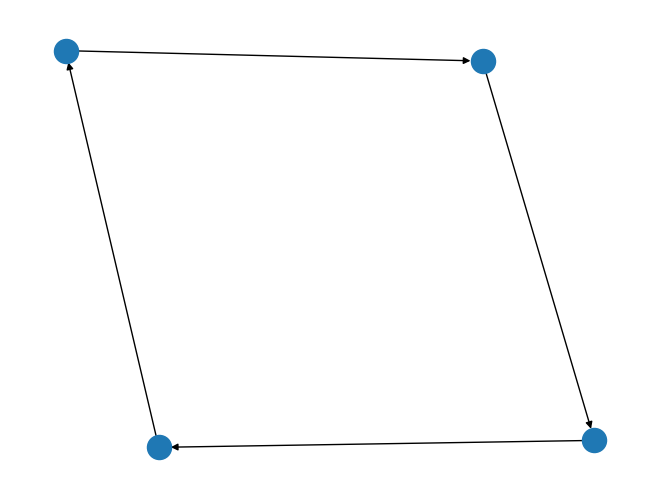

In [ ]:
import networkx as nx
nx.draw(cycle)

#pos = {node:(nodes[node].position,nodes[node].position)}
#nx.draw(T, pos=...) 

# Local Search Plots

In [6]:
from uav_routing.optimization import Optimizer
import matplotlib.pyplot as plt

total_steps = 1000

import numpy as np

#----- Short Bursts
max_scores_as = np.zeros(total_steps)
scores_as = np.zeros(total_steps)

for i, part in enumerate(optimizer.ascent_run(total_steps, with_progress_bar=True)):
    max_scores_as[i] = optimizer.best_score
    scores_as[i] = optimizer.score(part)


#----- Short Bursts
max_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)

for i, part in enumerate(optimizer.short_bursts(num_bursts=5, burst_length=2000, with_progress_bar=True)):
    max_scores_sb[i] = optimizer.best_score
    scores_sb[i] = optimizer.score(part)


#----- Simulated Annealing
max_scores_anneal = np.zeros(total_steps)
scores_anneal = np.zeros(total_steps)

for i, part in enumerate(
    optimizer.simulated_annealing(
        total_steps,
        optimizer.jumpcycle_beta_function(200, 800),
        beta_magnitude=1,
        with_progress_bar=True
    )
):
    max_scores_anneal[i] = optimizer.best_score
    scores_anneal[i] = optimizer.score(part)


# ----- Short Busts
max_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)

for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    max_scores_tilt[i] = optimizer.best_score
    scores_tilt[i] = optimizer.score(part)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<00:00, 1075.19it/s]

methods [<function add_random_node at 0x16a281800>, <function remove_random_node at 0x16a281760>, <function swap_two_nodes at 0x16a281580>, <function replace_random_node at 0x16a2816c0>]
chosen method <function add_random_node at 0x16a281800>
tour nodes before operation [0, 3, 6]
tour edges before operation [(0, 3), (3, 6), (6, 0)]
tour nodes after [0, 3, 6, 2]
tour edges after [(0, 2), (3, 6), (6, 0), (2, 3)]
flows Flows(nodes_out=frozenset(), nodes_in=frozenset({2}), edges_out=frozenset({(0, 3)}), edges_in=frozenset({(2, 3), (0, 2)}))
Couldn't uptade the solver.


TypeError: exceptions must derive from BaseException

In [8]:
seq = [3]
seq[0]

3

In [6]:
seq = [1,2,3,5]
a=3

idx = seq.index(a)
seq[idx+1]

5

In [26]:
for i in range(len(seq)):
    print(i)

0
1


In [ ]:
import random
seq = [3,5]
i = random.randrange(len(seq))
i = 0 -> seq[i] =3

0

In [20]:
seq[i]

3

In [ ]:
def swap_two_nodes(base, dest, seq, unused_nodes): # len(seq) >= 2
    "Switch the places of two random numbers in the seq"
    print("swap two random nodes selected")
    sampled = random.sample(range(len(seq)), 2)
    i, j = sorted(sampled)
    
    if i > 0:
        left =seq[i-1]
    else:
        i_left = base
    
    if i == j-1:
        i_right = j
        j_left = i
    else:
        i_right = seq[i+1]
        j_left = seq[j-1]
    
    if j < len(seq)-1:    
        j_right = seq[i+1]
    else: 
        j_right = dest
    
    new_left, new_right = seq[i], seq[j]   
    seq[i], seq[j] = seq[j], seq[i]
    
    n_out = set()
    n_in = set()
    e_out = {(i_left, new_left), (new_left, i_right), (j_left, new_right), (new_right, j_right)}
    e_in = {(i_left, new_right), (new_right, i_left), (j_left, new_left), (new_left, j_right)}
    
    flows = Flows(nodes_out=n_out,
                 nodes_in=n_in,
                 edges_out=e_out,
                 edges_in=e_in)
    print("leaving..")
    return flows, seq, unused_nodes

"""
swap two random nodes selected
leaving..
flows Flows(edges_out={(3, 1), ((0, 0), 3), (6, 9), (0, 6)}, edges_in={(6, (0, 0)), (3, 9), ((0, 0), 6), (0, 3)})
Removing failed: Model does not have any constraint for edge (3, 1)!
"""

In [38]:
seq= [2,5,6,7,8,1,4]
base = 0
dest = 10
import random
i = random.randrange(len(seq))   

old_x = seq[i]
if i >0:
    left = seq[i-1]
else:
    left = base

if i < len(seq)-1:    
    right = seq[i+1]
else: 
    right = dest
if i < len(seq)-1:    
    right = seq[i+1]
print("selected", old_x)
print("left", left)
print("right", right)

selected 4
left 1
right 10


In [5]:
tourr= [2,5,6,7,8,1,4]

def _tour_edges(tour):
    tour_edges = []
    for i in tour[0:-1]:
        idx = tour.index(i)
        tour_edges.append((i, tour[idx+1]))
    return tour_edges

see =_tour_edges(tourr)
see

[(2, 5), (5, 6), (6, 7), (7, 8), (8, 1), (1, 4)]

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(max_scores_as, label="Ascent Run")
plt.plot(max_scores_sb, label="Short Bursts")
plt.plot(max_scores_anneal, label="Simulated Annealing")
plt.plot(max_scores_tilt, label="Tilted Run")

plt.xlabel("Steps", fontsize=20)
plt.ylabel("Max Information Collection Observered", fontsize=20)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(scores_as, label="Ascent Run")
plt.plot(scores_sb, label="Short Bursts")
plt.plot(scores_anneal, label="Simulated Annealing")
plt.plot(scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Total Collected Info", fontsize=20)
plt.legend(fontsize=9)
plt.show()

# Geometric Plot

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8,8))
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Initial Partition in MN")
initial_partition.plot(ax=ax, cmap='tab20c')

In [ ]:
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import pandas as pd

import matplotlib.cm as mcm
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

frames = []
district_data = []

for i, partition in enumerate(recom_chain):
    for district_name in partition.perimeter.keys():
        population = partition.population[district_name]
        perimeter = partition.perimeter[district_name]
        area = partition.area[district_name]
        district_data.append((i, district_name, population, perimeter, area))

    buffer = io.BytesIO()
    fig, ax = plt.subplots(figsize=(10,10))
    partition.plot(ax=ax, cmap='tab20')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    frames.append(image)
    plt.close(fig)

df = pd.DataFrame(
    district_data,
    columns=[
        'step',
        'district_name',
        'population',
        'perimeter',
        'area'
    ]
)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
slider.layout.width = '500px'
widgets.interactive(show_frame, idx=slider)
